In [1]:
import glob
import json
import pandas as pd
import tensorflow as tf
import spacy
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Flatten, Concatenate, TimeDistributed, Bidirectional, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow import TensorShape
import tensorflow_addons as tfa
from langdetect import detect
import itertools

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
%%time

path = '/home/ubuntu/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])

#get the lengths of texts
data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))

#filter papers with certain word length
data.query('len_bt <= 1000 and len_bt>=100 and len_ab <= 500 and len_ab >=20', inplace = True)

#detect languages of texts to filter out non-english papers
data['bt_lang'] = data.bodytext.map(lambda x: detect(x))
data['ab_lang'] = data.abstract.map(lambda x: detect(x))

#use only english papers
data = data[(data['bt_lang'] == 'en') & (data['ab_lang'] == 'en')]

CPU times: user 13.4 s, sys: 1.88 s, total: 15.3 s
Wall time: 29.6 s


In [4]:
data.describe()

,len_bt,len_ab
count,183.000000,183.000000
mean,586.874317,117.213115
std,236.601326,92.766891
min,101.000000,28.000000
25%,419.000000,51.000000
50%,557.000000,84.000000
75%,815.000000,156.000000
max,999.000000,500.000000


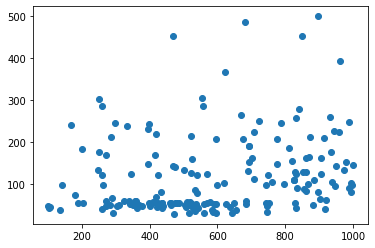

In [5]:
plt.scatter(data.len_bt,data.len_ab)

In [6]:
def clean_text(bodytext):
    cleaned = list()
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for word in bodytext:
        words = str(word)       
        words = words.lower()
        words = words.translate(table)
        words = re_print.sub('', words) 
        if words.isalpha() == True:
            cleaned.append(words)
    cleaned.insert(0, '<start>')
    cleaned.append('<end>')
    return cleaned

In [7]:
%%time

nlp = spacy.load("en_core_web_lg")
bt_vector = list()
bt_list = []
ab_list = []
for i in range(len(data)):
    bodytext = nlp(data.iloc[i].bodytext)
    bt_clean = clean_text(bodytext)
    bt_list.append(bt_clean)
    
    abstract = nlp(data.iloc[i].abstract)
    ab_clean = clean_text(abstract)
    ab_list.append(ab_clean)
com_list = ab_list + bt_list
    #c_papers.append(papers)
bt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
bt_tokenizer.fit_on_texts(com_list)
data_bt = bt_tokenizer.texts_to_sequences(bt_list)
data_ab = bt_tokenizer.texts_to_sequences(ab_list)

longest_seq = max(max([len(x) for x in data_bt]), max([len(x) for x in data_ab]))
#x_voc_size = max([len(x) for x in data_bt])#, max([len(x) for x in data_ab]))
#y_voc_size = max([len(y) for y in data_ab])
data_bt = tf.keras.preprocessing.sequence.pad_sequences(data_bt,padding='post', maxlen = longest_seq)
data_ab = tf.keras.preprocessing.sequence.pad_sequences(data_ab,padding='post', maxlen = longest_seq) 

CPU times: user 30 s, sys: 615 ms, total: 30.6 s
Wall time: 37.9 s


In [8]:
def max_len(tensor):
    #print( np.argmax([len(t) for t in tensor]))
    return max( len(t) for t in tensor)

In [9]:

X_train,  X_test, Y_train, Y_test = train_test_split(data_bt,data_ab,test_size=0.2)
BATCH_SIZE = 50
BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 256
rnn_units = 128
dense_units = 128
Dtype = tf.float32
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [10]:
#get abstracts no longer than 100 words, 

a = bt_tokenizer.word_index
print(list(a.keys())[list(a.values()).index(9326)])

In [11]:
vocab_size = len(bt_tokenizer.word_index)+1  
vocab_size

9684

In [12]:
X_train

array([[  27,  535,    3, ...,    0,    0,    0],
       [  27,  365,   75, ...,    0,    0,    0],
       [  27,    1,  403, ...,    0,    0,    0],
       ...,
       [  27,  229, 7968, ...,    0,    0,    0],
       [  27, 1377,   11, ...,    0,    0,    0],
       [  27,    6,  171, ...,    0,    0,    0]], dtype=int32)

In [13]:
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]
encoder_initial_cell_state = initialize_initial_state()

In [14]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        self.encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab_size,
                                                           output_dim=embedding_dims)
        self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences=True, 
                                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab_size,
                                                           output_dim=embedding_dims) 
        self.dense_layer = tf.keras.layers.Dense(output_vocab_size)
        self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[longest_seq])
        self.rnn_cell =  self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler= self.sampler,
                                                output_layer=self.dense_layer)

    def build_attention_mechanism(self, units,memory, memory_sequence_length):
        return tfa.seq2seq.LuongAttention(units, memory = memory, 
                                          memory_sequence_length=memory_sequence_length)
        #return tfa.seq2seq.BahdanauAttention(units, memory = memory, memory_sequence_length=memory_sequence_length)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size ):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism,
                                                attention_layer_size=dense_units)
        return rnn_cell
    
    def build_decoder_initial_state(self, batch_size, encoder_state,Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 
        return decoder_initial_state

encoderNetwork = EncoderNetwork(vocab_size,embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(vocab_size,embedding_dims, rnn_units)
optimizer = tf.keras.optimizers.Adam()

In [46]:
tf.saved_model.save(encoderNetwork, "./covid_encoder")
tf.saved_model.save(decoderNetwork, "./covid_decoder")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./covid_encoder/assets
INFO:tensorflow:Assets written to: ./covid_decoder/assets


In [16]:
vocab_size, longest_seq, steps_per_epoch

(9684, 959, 2)

In [17]:
def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss

def train_step(input_batch, output_batch,encoder_initial_cell_state):
    #initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state =encoder_initial_cell_state)

        #[last step activations,last memory_state] of encoder passed as input to decoder Network
        
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore <end>
        #compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore <start>


        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        #BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[longest_seq-1])

        logits = outputs.rnn_output
        #Calculate loss

        loss = loss_function(logits, decoder_output)

    #Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    #grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

In [18]:
epochs = 2
for i in range(1, epochs+1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0

    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        if (batch+1)%5 == 0:
            print("total loss: {} epoch {} batch {} ".format(batch_loss.numpy(), i, batch+1))

In [19]:
encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
encoder_emb_inp

<tf.Tensor: shape=(50, 959, 256), dtype=float32, numpy=
array([[[-0.00991693, -0.01446358,  0.02853112, ..., -0.0430769 ,
         -0.04316779,  0.0106885 ],
        [ 0.02633841, -0.04571971,  0.04504414, ..., -0.01970328,
         -0.03171159,  0.03187238],
        [-0.00557921, -0.00554545, -0.04175382, ..., -0.02747589,
         -0.03312651,  0.02503815],
        ...,
        [ 0.00774547, -0.03388133,  0.040099  , ...,  0.04583717,
          0.03554945,  0.046782  ],
        [ 0.00774547, -0.03388133,  0.040099  , ...,  0.04583717,
          0.03554945,  0.046782  ],
        [ 0.00774547, -0.03388133,  0.040099  , ...,  0.04583717,
          0.03554945,  0.046782  ]],

       [[-0.00991693, -0.01446358,  0.02853112, ..., -0.0430769 ,
         -0.04316779,  0.0106885 ],
        [-0.04813649,  0.01817832, -0.02858244, ..., -0.00870688,
          0.04454856, -0.04202262],
        [ 0.00587633, -0.03932049, -0.04086987, ..., -0.01227671,
         -0.00820951,  0.04256004],
        ...

In [ ]:
input_raw= X_test[0]

#inp = tf.convert_to_tensor(input_raw)
encoder_initial_cell_state1 = [tf.zeros((50, rnn_units)),
                             tf.zeros((50, rnn_units))]
encoder_emb_inp1 = encoderNetwork.encoder_embedding(input_raw)
a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp1,
                                               initial_state =encoder_initial_cell_state1)

# print('a_tx :', a_tx.shape)
# print('c_tx :', c_tx.shape)
encoder_emb_inp1

In [34]:
input_raw.reshape(1,-1).shape

(1, 959)

In [ ]:
#In this section we evaluate our model on a raw_input converted to german, for this the entire sentence has to be passed
#through the length of the model, for this we use greedsampler to run through the decoder
#and the final embedding matrix trained on the data is used to generate embeddings
input_raw=X_test[0].reshape(1,-1)
# inp_bodytext = nlp(input_raw)
# input_lines = clean_text(inp_bodytext)

# We have a transcript file containing English-German pairs
# Preprocess X
#input_raw = clean_text(input_raw)
#input_lines = [f'{bt_tok} {input_raw}']
# input_sequences = [[bt_tokenizer.word_index[w] for w in line.split()] for line in input_raw]
# input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_raw,
#                                                                maxlen=longest_seq, padding='post')
# inp = tf.convert_to_tensor(input_sequences)

#print("inp", inp.shape)
#print("inp_seq",input_sequences)
# inference_batch_size = input_sequences.shape[0]
encoder_initial_cell_state = [tf.zeros((1, rnn_units)),tf.zeros((1, rnn_units))]
encoder_emb_inp = encoderNetwork.encoder_embedding(input_raw)
a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,initial_state =encoder_initial_cell_state)
print('a_tx :', a_tx.shape)
print('c_tx :', c_tx.shape)

start_tokens = tf.fill([1],bt_tokenizer.word_index['<start>'])

end_token = bt_tokenizer.word_index['<end>']

greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

decoder_input = tf.expand_dims([bt_tokenizer.word_index['<start>']]* 1,1)
decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, sampler = greedy_sampler,
                                            output_layer=decoderNetwork.dense_layer)
decoderNetwork.attention_mechanism.setup_memory(a)
#pass [ last step activations , encoder memory_state ] as input to decoder for LSTM
print(f"decoder_initial_state = [a_tx, c_tx] : {np.array([a_tx, c_tx]).shape}")
decoder_initial_state = decoderNetwork.build_decoder_initial_state(1,
                                                                   encoder_state=[a_tx, c_tx],
                                                                   Dtype=tf.float32)
print(f"""
Compared to simple encoder-decoder without attention, the decoder_initial_state
is an AttentionWrapperState object containing s_prev tensors and context and alignment vector

decoder initial state shape: {np.array(decoder_initial_state).shape}
decoder_initial_state tensor
{decoder_initial_state}
""")

# Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
# One heuristic is to decode up to two times the source sentence lengths.
maximum_iterations = tf.round(tf.reduce_max(longest_seq) * 2)

#initialize inference decoder
decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
(first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                             start_tokens = start_tokens,
                             end_token=end_token,
                             initial_state = decoder_initial_state)
#print( first_finished.shape)
print(f"first_inputs returns the same decoder_input i.e. embedding of  {'<start>'} : {first_inputs.shape}")
print(f"start_index_emb_avg {tf.reduce_sum(tf.reduce_mean(first_inputs, axis=0))}") # mean along the batch

inputs = first_inputs
state = first_state  
predictions = np.empty((1,0), dtype = np.int32)                                                                             
for j in range(maximum_iterations):
    outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
    inputs = next_inputs
    state = next_state
    outputs = np.expand_dims(outputs.sample_id,axis = -1)
    predictions = np.append(predictions, outputs, axis = -1)

In [ ]:
print("\nSummary:")
for i in range(len(predictions)):
    line = predictions[i,:]
    seq = list(itertools.takewhile( lambda index: index !=2, line))
    print(" ".join( [bt_tokenizer.index_word[w] for w in seq]))

In [41]:
predictions

array([[1, 1, 1, ..., 1, 1, 1]], dtype=int32)